# Power Spectra Plotting Tutorial

This notebook explores how to correctly plot power spectra for filtered and unfiltered data. This process requires converting our data from latitude-longitude coordinates (degrees) to kilometer coordinates.

In the xrft package, frequency is defined as follows. Frequency $f$ is calculated based off np.fft.fftfreq. Specifically,

$f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)$,  if $n$ even\
$f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)$,  if $n$ is odd

This means that, by default, xrft calculating frequency with units $degrees^{-1}$. Because the distance corresponding with one degree is different at different locations on Earth, we need frequency with units $km^{-1}$.

### Loading the dataset

In [15]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import gcm_filters
import xrft

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data
from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

In [16]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Choose a region of the map

In [17]:
x_min, x_max = 700, 1300
y_min, y_max = 1500, 1800

In [49]:
temp = ds_merged.surface_temp.isel(time=-1).isel(yt_ocean=slice(y_min, y_max), xt_ocean=slice(x_min, x_max))

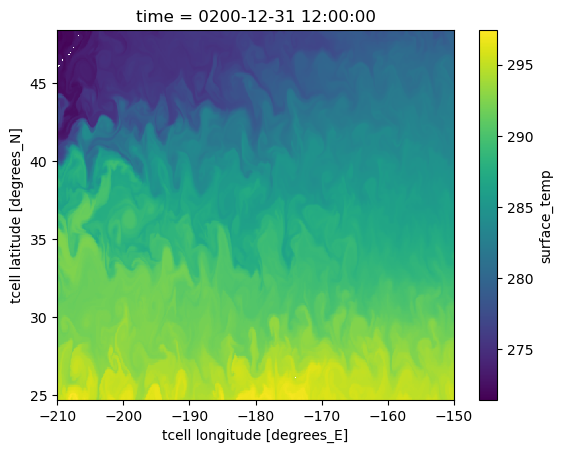

In [19]:
temp.plot()

### Converting from degrees to km

Latitude and longitude can be converted from units of degrees to km as follows\
    $lat_{km} = lat_{deg} * 111.32 km$ \
    $lon_{km} = lon_{deg} * 111.32 km * cos(rad(lat_{deg}))$ 

__Our steps for the conversion are outlined below.__
1. Calculate xt_ocean in km 
    1. Set the start of our array at xt_ocean[0]
    2. Multiply by lat2km conversion
    3. Broadcast array to a meshgrid for xt_ocean, yt_ocean, where each xt_ocean value is the same across a row.
    4. Multiply each row by cosine of the yt_ocean (latitude) values in radians.
2. Calculate yt_ocean in km 
    1. Set the start of our array at yt_ocean[0]
    2. Multiply by lat2km conversion

In [50]:
lat2km = 110
xt_km = (temp.xt_ocean - temp.xt_ocean[0] ) * lat2km * (temp.yt_ocean*.0 + 1) * np.cos(temp.yt_ocean*np.pi/180)
yt_km = (temp.yt_ocean - temp.yt_ocean[0] ) * lat2km

In [51]:
print(yt_km.shape) 
print(xt_km.shape)

(300,)
(600, 300)


Text(0, 0.5, 'Latitude')

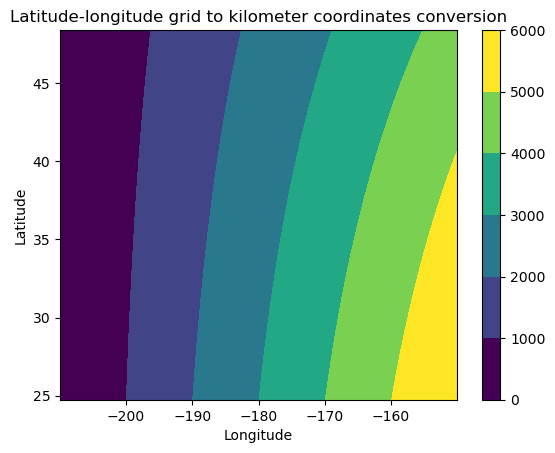

In [29]:
xt_km.plot.contourf(x='xt_ocean')
plt.title("Latitude-longitude grid to kilometer coordinates conversion")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

We add xt_km and yt_km as coordinates into our DataArray temp. Then, we bundle all the relevant information into a DataSet temp_ds.

In [52]:
temp['xt_km'] = xt_km
temp['yt_km'] = yt_km

In [53]:
temp = temp.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
temp

<xarray.DataArray 'surface_temp' (yt_ocean: 300, xt_ocean: 600)>
dask.array<getitem, shape=(300, 600), dtype=float32, chunksize=(300, 600), chunktype=numpy.ndarray>
Coordinates:
    time      object 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -150.3 -150.2 -150.1
  * yt_ocean  (yt_ocean) float64 24.74 24.83 24.92 25.02 ... 48.26 48.33 48.39
    xt_km     (xt_ocean, yt_ocean) float64 0.0 0.0 0.0 ... 4.381e+03 4.375e+03
    yt_km     (yt_ocean) float64 0.0 9.986 19.97 ... 2.594e+03 2.602e+03

In [54]:
temp_ds = xr.Dataset()
temp_ds['SST'] = temp

In [55]:
temp_ds

<xarray.Dataset>
Dimensions:   (xt_ocean: 600, yt_ocean: 300)
Coordinates:
    time      object 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -150.3 -150.2 -150.1
  * yt_ocean  (yt_ocean) float64 24.74 24.83 24.92 25.02 ... 48.26 48.33 48.39
    xt_km     (xt_ocean, yt_ocean) float64 0.0 0.0 0.0 ... 4.381e+03 4.375e+03
    yt_km     (yt_ocean) float64 0.0 9.986 19.97 ... 2.594e+03 2.602e+03
Data variables:
    SST       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 600), meta=np.ndarray>

### Filter the dataset

In [56]:
temp_filt = filter_inputs_dataset(temp_ds, ['yt_ocean', 'xt_ocean'], filter_scale=10, filter_type='gaussian')

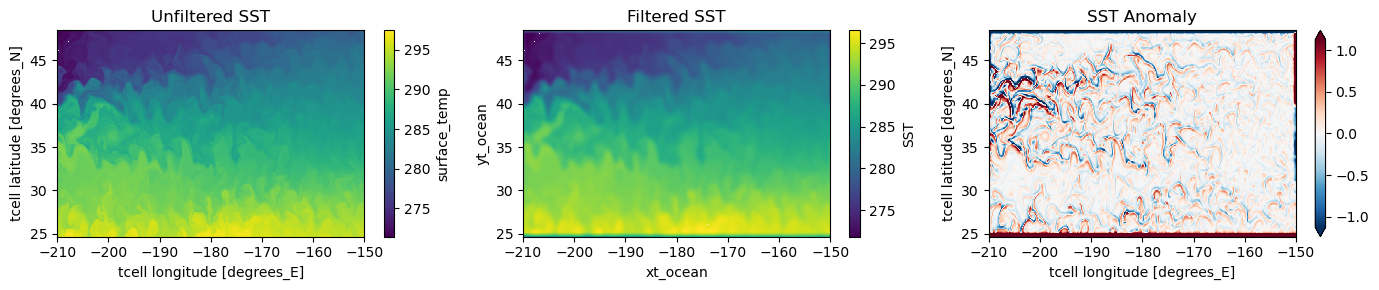

In [57]:
plt.figure(figsize=(14, 3))

plt.subplot(131)
temp.plot()
plt.title("Unfiltered SST")

plt.subplot(132)
temp_filt.SST.plot()
plt.title("Filtered SST")

plt.subplot(133)
(temp - temp_filt.SST).plot(robust=True)
plt.title("SST Anomaly")

plt.tight_layout()

### Calculate the power spectra

In [61]:
temp_ps = xrft.power_spectrum(temp.drop(['xt_km', 'yt_km']), dim=['xt_ocean'], window=True)
temp_ps

<xarray.DataArray 'rechunk-merge-fbdb6b47def7c928e883f8c29f8acc51' (
                                                                    yt_ocean: 300,
                                                                    freq_xt_ocean: 600)>
dask.array<mul, shape=(300, 600), dtype=float64, chunksize=(300, 600), chunktype=numpy.ndarray>
Coordinates:
    time           object 0200-12-31 12:00:00
  * yt_ocean       (yt_ocean) float64 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * freq_xt_ocean  (freq_xt_ocean) float64 -5.0 -4.983 -4.967 ... 4.967 4.983

In [62]:
temp_filt_ps = xrft.power_spectrum(temp_filt.SST.drop(['xt_km', 'yt_km']), dim=['xt_ocean'], window=True)
temp_filt_ps

<xarray.DataArray 'rechunk-merge-c9298f0706e8ce0460afa7288a6d6c7a' (
                                                                    yt_ocean: 300,
                                                                    freq_xt_ocean: 600)>
dask.array<mul, shape=(300, 600), dtype=float64, chunksize=(300, 600), chunktype=numpy.ndarray>
Coordinates:
    time           object 0200-12-31 12:00:00
  * yt_ocean       (yt_ocean) float64 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * freq_xt_ocean  (freq_xt_ocean) float64 -5.0 -4.983 -4.967 ... 4.967 4.983

### Find significant frequencies 

In [63]:
dx_lon = temp.xt_ocean.diff('xt_ocean')[0]

In [64]:
nyquist_freq = 1/(2*dx_lon) # largest freq/wavenumber, smallest scale

In [67]:
smallest_freq = 1/np.abs(temp.xt_ocean[0] - temp.xt_ocean[-1]) # smallest freq/wavenumber, largest scale

In [66]:
filter_cut_off_freq = 1/(10*dx_lon)

### Plot power spectra with frequency in 1/km units
Frequency is in 1/degrees. We want it to be in 1/km, so we perform the same conversions shown above.

In [70]:
freq_x_km = temp_ps.freq_xt_ocean * ( 1 / (lat2km * np.cos(temp_ps.yt_ocean.mean('yt_ocean') * np.pi/180)) )

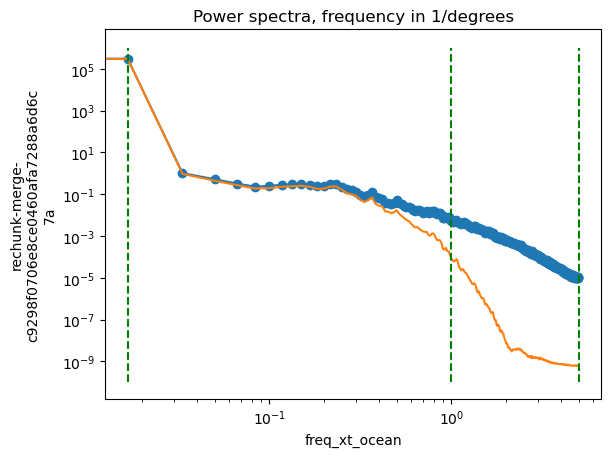

In [104]:
temp_ps.mean('yt_ocean').plot(marker='o')
temp_filt_ps.mean('yt_ocean').plot()
plt.title("Power spectra, frequency in 1/degrees")

plt.vlines([nyquist_freq, smallest_freq, filter_cut_off_freq], 1e-10, 1e6, colors='green', linestyle='--')
plt.xscale('log')
plt.yscale('log')

In [96]:
ps_min = min(min(temp_ps.mean('yt_ocean').values), min(temp_filt_ps.mean('yt_ocean').values))
ps_max = max(max(temp_ps.mean('yt_ocean').values), max(temp_filt_ps.mean('yt_ocean').values))

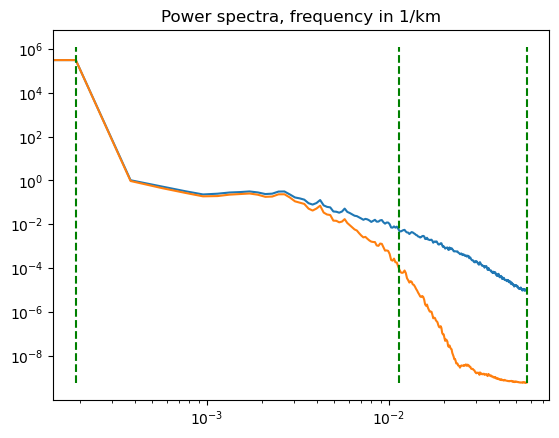

In [105]:
plt.plot(freq_x_km, temp_ps.mean('yt_ocean')) #plot(marker='o')
plt.plot(freq_x_km, temp_filt_ps.mean('yt_ocean'))
plt.title("Power spectra, frequency in 1/km")

nyquist_freq_km = nyquist_freq * ( 1 / (lat2km * np.cos(temp_ps.yt_ocean.mean('yt_ocean') * np.pi/180)) )
smallest_freq_km = smallest_freq * ( 1 / (lat2km * np.cos(temp_ps.yt_ocean.mean('yt_ocean') * np.pi/180)) )
filter_cut_off_freq_km = filter_cut_off_freq * ( 1 / (lat2km * np.cos(temp_ps.yt_ocean.mean('yt_ocean') * np.pi/180)) )

plt.vlines([nyquist_freq_km, smallest_freq_km, filter_cut_off_freq_km], ps_min, ps_max, colors='green', linestyle='--')
plt.xscale('log')
plt.yscale('log')